In [1]:
#!/usr/bin/python3
# coding: -*- utf-8 -*-
# MHLW

In [2]:
from datetime import datetime as dt
from datetime import timedelta as td
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
from cov19utils import create_basic_plot_figure, \
    show_and_clear, moving_average, \
    blank2zero, csv2array, \
    get_twitter, tweet_with_image, \
    get_gpr_predict, FONT_NAME, DT_OFFSET, \
    download_if_needed

In [3]:
# 厚労省の OpenData を参照する
base_uri = "https://www.mhlw.go.jp/content/"

raws = dict(
    posis = "pcr_positive_daily.csv",
    # 日別PCR検査人数よりも検査機関別の数値を使用すべき
    tests = "pcr_tested_daily.csv",
    cases = "cases_total.csv",
    recov = "recovery_total.csv",
    death = "death_total.csv",
    pcr = "pcr_case_daily.csv")

offsets = dict(
    dates = 0, # 日付オフセット
    cases = 1, # 入院治療を要する者(Total)
    death = 2, # 死亡者数(Total)
    pcr   = 3, # PCR検査 件数：感染研、検疫、保健所、民間、大学、医療機関(Daily), 
    pcrs  = 9, # 上記の合算
    posis = 10, # 陽性者数(Daily)
    tests = 11, # PCR検査 人数(Daily)
    recov = 12, # 退院（Total)
    ratio = 13, # 陽性率(Daily) = 陽性者数 / 検査人数
    total = 14, # 陽性者数(Total)
    ) # 

# 集計期間
dt_range = (dt.today() - dt.strptime(DT_OFFSET, "%Y/%m/%d")).days
# 配列初期化
all_data_arr = []
for i in np.arange(dt_range):
    all_data_arr.append([i, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
# データの取得
for k, v in raws.items():
    download_if_needed(base_uri, v)
# データの集計
for k, v in raws.items():
    if v != 0:
        csv2array(all_data_arr, k, v, offsets[k])
# 陽性率等の計算
for i in np.arange(dt_range):
    div = all_data_arr[i][offsets['pcrs']]
    if div != 0:
        all_data_arr[i][offsets['ratio']] = max(0, min(100, (all_data_arr[i][offsets['posis']] / div) * 100))
    if i == 0:
        all_data_arr[i][offsets['total']] = all_data_arr[i][offsets['posis']]
    else:
        all_data_arr[i][offsets['total']] = all_data_arr[i][offsets['posis']] + all_data_arr[i-1][offsets['total']]

all_data_np = np.array(all_data_arr)

file: pcr_positive_daily.csv enc: UTF-8-SIG
file: pcr_tested_daily.csv enc: UTF-8-SIG
file: cases_total.csv enc: UTF-8-SIG
file: recovery_total.csv enc: UTF-8-SIG
file: death_total.csv enc: UTF-8-SIG
file: pcr_case_daily.csv enc: UTF-8-SIG


In [4]:
print("{}".format((dt.strptime(DT_OFFSET, "%Y/%m/%d") + td(days=all_data_np[-1][0])).isoformat()[:10]))

2020-10-03


In [5]:
from_date = dt.strptime(DT_OFFSET, "%Y/%m/%d")
xbins = [from_date + td(days=i) for i in range(dt_range)]
days2pred = 4 * 7
xbins_pred = [from_date + td(days=i) for i in range(dt_range + days2pred)]

In [6]:
ave_mov_days = 7
# 移動平均を算出する
posis_mov_mean = moving_average(all_data_np[:, offsets['posis']])
ratio_mov_mean = moving_average(all_data_np[:, offsets['ratio']])
print("陽性者数(移動平均): {}".format(posis_mov_mean[-1]))
print("　陽性率(移動平均): {}".format(ratio_mov_mean[-1]))

陽性者数(移動平均): 433.2857142857143
　陽性率(移動平均): 2.2322438947258023


In [7]:
X = np.arange(0, len(posis_mov_mean))[:, np.newaxis]
X_pred = np.arange(0, len(xbins_pred))[:, np.newaxis]
y_posis = get_gpr_predict(X, all_data_np[:, offsets['posis']], X_pred, 80, 10, 200)
y_ratio = get_gpr_predict(X, all_data_np[:, offsets['ratio']], X_pred, 80, 10, 200)

y 1 val = 537.0.
data 262 offset = -2.
y 2 val = 3.2372044686931676.
data 262 offset = -3.


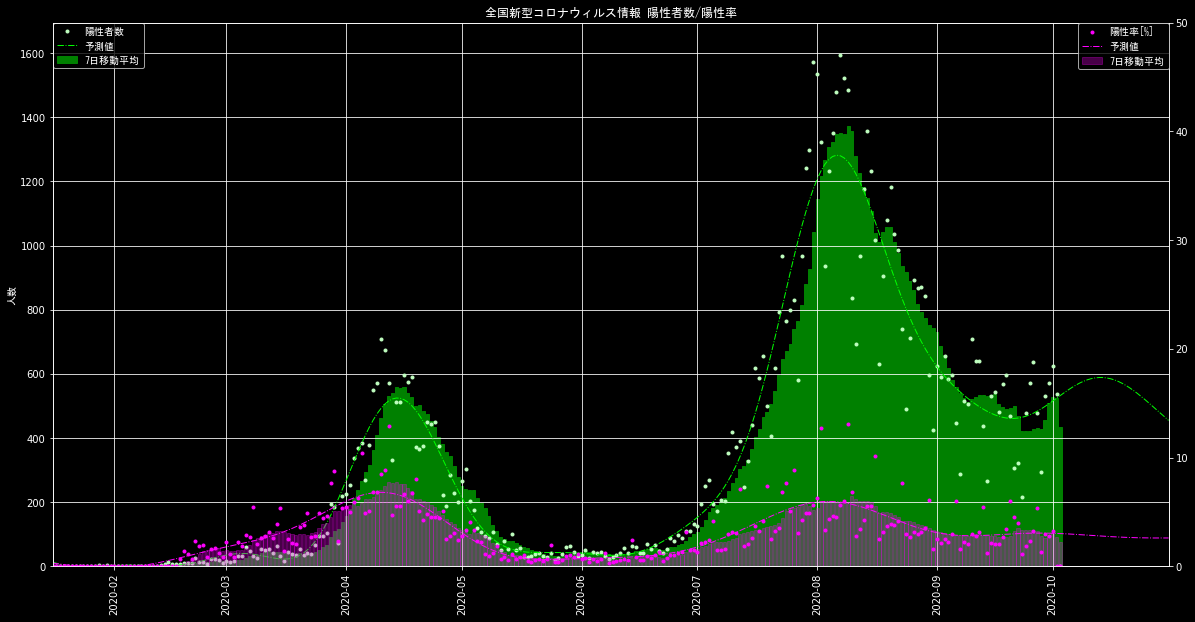

In [8]:
fig, ax = create_basic_plot_figure()
plt.xlim(xbins_pred[0], xbins_pred[-1])
plt.ylim(0, max(all_data_np[:, offsets['posis']])+100)
plt.plot(xbins, all_data_np[:, offsets['posis']], '.', linewidth=1, color='#c0ffc0')
plt.plot(xbins_pred, y_posis, '-.', color='#00ff00', linewidth=1)
plt.bar(xbins, posis_mov_mean, color='#008000', edgecolor='#008000', alpha=1)
plt.legend(labels=["陽性者数", "予測値", "7日移動平均"], loc='upper left', borderaxespad=0, fontsize=12, prop={"family":FONT_NAME})
plt.title('全国新型コロナウィルス情報 陽性者数/陽性率', fontname=FONT_NAME)
ax2 = ax.twinx()
plt.ylim(0, 50)
ax2.plot(xbins, all_data_np[:, offsets['ratio']], '.', linewidth=1, color='#ff00ff')
ax2.plot(xbins_pred, y_ratio, '-.', color="#ff00ff", linewidth=1)
ax2.bar(xbins, ratio_mov_mean, color='#f000f0', edgecolor='#f000f0', alpha=0.3)
plt.legend(labels=["陽性率[%]", "予測値", "7日移動平均"], loc='upper right', borderaxespad=0, fontsize=12, prop={"family":FONT_NAME})
show_and_clear(fig, "mhlw-posis.jpg")

In [9]:
y_tests = get_gpr_predict(X, all_data_np[:, offsets['pcrs']], X_pred, 1, 1, 5)

y 2 val = 19245.0.
data 262 offset = -3.


検査人数(移動平均): 12717.0


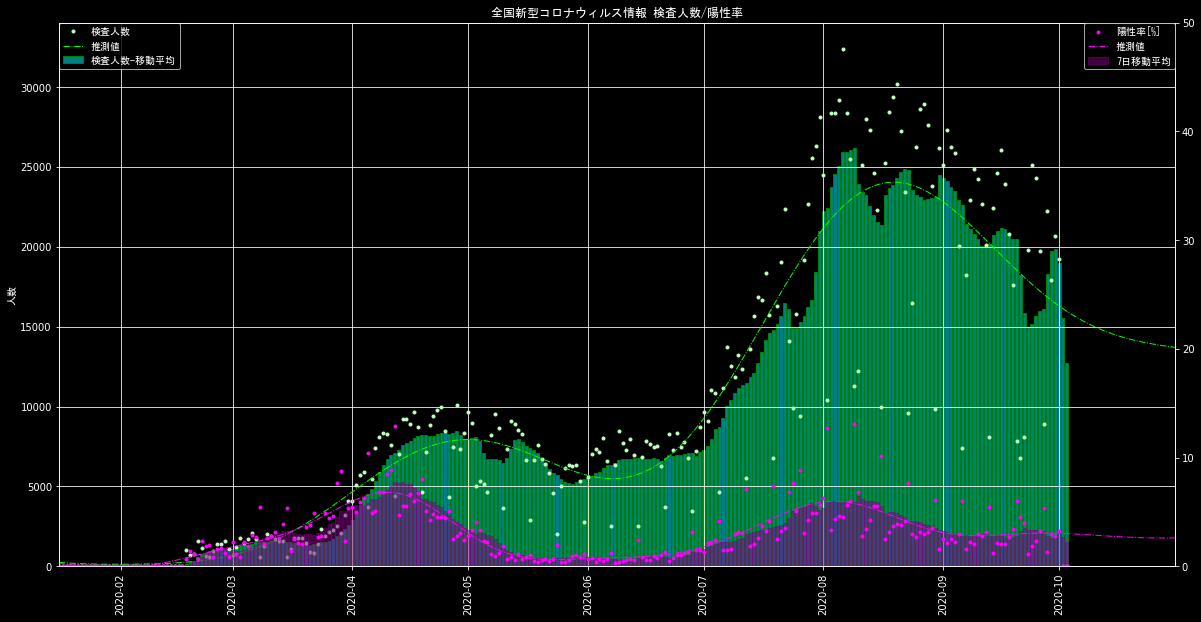

In [10]:
# 移動平均を算出する
tests_mov_mean = moving_average(all_data_np[:, offsets['pcrs']])
print("検査人数(移動平均): {}".format(tests_mov_mean[-1]))
fig, ax = create_basic_plot_figure()
plt.xlim(xbins_pred[0], xbins_pred[-1])
plt.plot(xbins, all_data_np[:, offsets['pcrs']], '.', linewidth=1, color='#c0ffc0')
plt.plot(xbins_pred, y_tests, '-.', color='#00ff00', linewidth=1)
plt.bar(xbins, tests_mov_mean, color='#008080', edgecolor='#008000', alpha=1)
plt.legend(labels=["検査人数", "予測値", "検査人数-移動平均"], loc='upper left', borderaxespad=0, fontsize=12, prop={"family":FONT_NAME})
plt.title('全国新型コロナウィルス情報 検査人数/陽性率', fontname=FONT_NAME)
ax2 = ax.twinx()
plt.ylim(0, 50)
ax2.plot(xbins, all_data_np[:, offsets['ratio']], '.', linewidth=1, color='#ff00ff')
ax2.plot(xbins_pred, y_ratio, '-.', color="#ff00ff", linewidth=1)
ax2.bar(xbins, ratio_mov_mean, color='#800080', edgecolor='#800080', alpha=0.5)
plt.legend(labels=["陽性率[%]", "予測値", "7日移動平均"], loc='upper right', borderaxespad=0, fontsize=12, prop={"family":FONT_NAME})
show_and_clear(fig, "mhlw-tests.jpg")

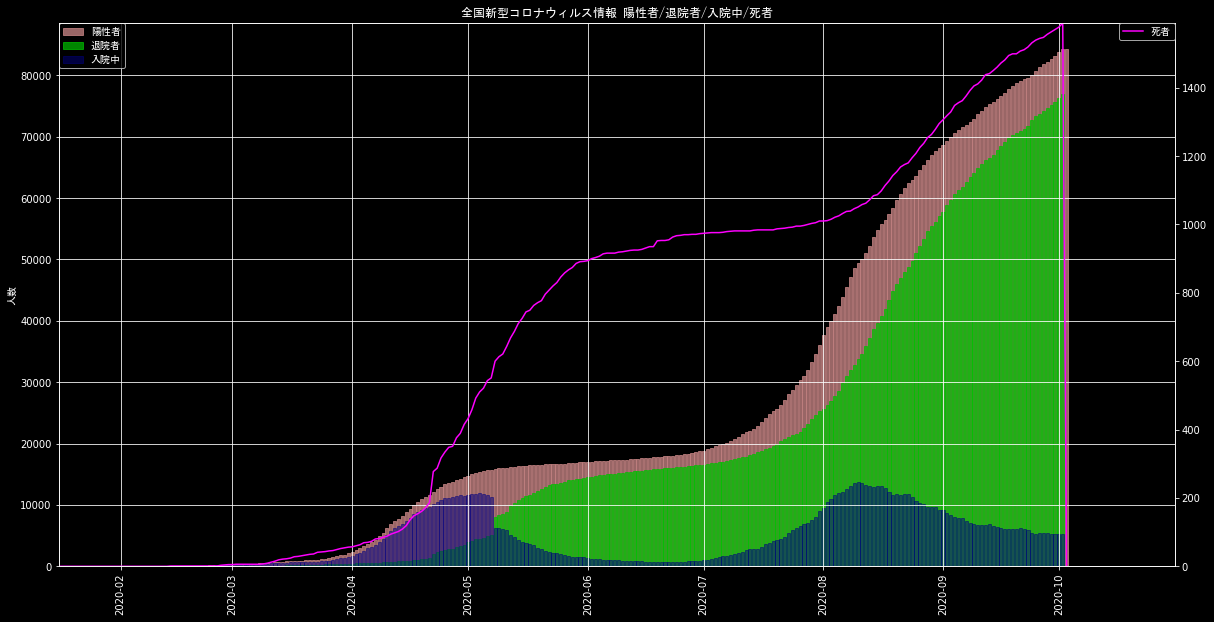

In [11]:
fig, ax = create_basic_plot_figure()
plt.xlim(xbins_pred[0], xbins_pred[-1])
plt.bar(xbins, all_data_np[:, offsets['total']], color='#c08080', edgecolor='#c08080', alpha=.8)
plt.bar(xbins, all_data_np[:, offsets['recov']], color='#00c000', edgecolor='#00c000', alpha=.7)
plt.bar(xbins, all_data_np[:, offsets['cases']], color='#000080', edgecolor='#000080', alpha=.5)
plt.legend(labels=["陽性者", "退院者", "入院中"], loc='upper left', borderaxespad=0, fontsize=12, prop={"family":FONT_NAME})
plt.title('全国新型コロナウィルス情報 陽性者/退院者/入院中/死者', fontname=FONT_NAME)
ax2 = ax.twinx()
ax2.plot(xbins, all_data_np[:, offsets['death']], color='magenta', alpha=1)
plt.legend(labels=["死者"], loc='upper right', borderaxespad=0, fontsize=12, prop={"family":FONT_NAME})
plt.ylim(0, max(all_data_np[:, offsets['death']])+1)
show_and_clear(fig, "mhlw-total.jpg")

In [12]:
today_str = dt.now().isoformat()[:19].replace('T', ' ')
tw_body_total = "全国新型コロナ 累計の陽性者/退院者/死者＋2週間予測（厚労省 " + today_str + " 現在）"
tw_body_tests = "全国新型コロナ 検査人数/陽性率＋2週間予測（厚労省 " + today_str + " 現在）"
tw_body_posis = "全国新型コロナ 陽性者/陽性率＋2週間予測（厚労省 " + today_str + " 現在）"

In [14]:
tw = get_twitter()
tweet_with_image(tw, "mhlw-posis.jpg", tw_body_posis)
tweet_with_image(tw, "mhlw-tests.jpg", tw_body_tests)
tweet_with_image(tw, "mhlw-total.jpg", tw_body_total)

In [15]:
# 実効再生産数
ogiwara_uri = "https://raw.githubusercontent.com/kaz-ogiwara/covid19/master/data/"
ern_file = "effective_reproduction_number.csv"
download_if_needed(ogiwara_uri, ern_file)

In [16]:
ern_data_arr = []
for i in np.arange(dt_range):
    ern_data_arr.append([i, 0, 0, 0])
csv2array(ern_data_arr, 'ern', ern_file, 1)
ern_data_np = np.array(ern_data_arr)
#print(ern_data_np[:,1])

file: effective_reproduction_number.csv enc: utf-8


In [17]:
y_ern = get_gpr_predict(X, ern_data_np[:, 1], X_pred, 80, 10, 200)

y 1 val = 1.17.
data 262 offset = -2.


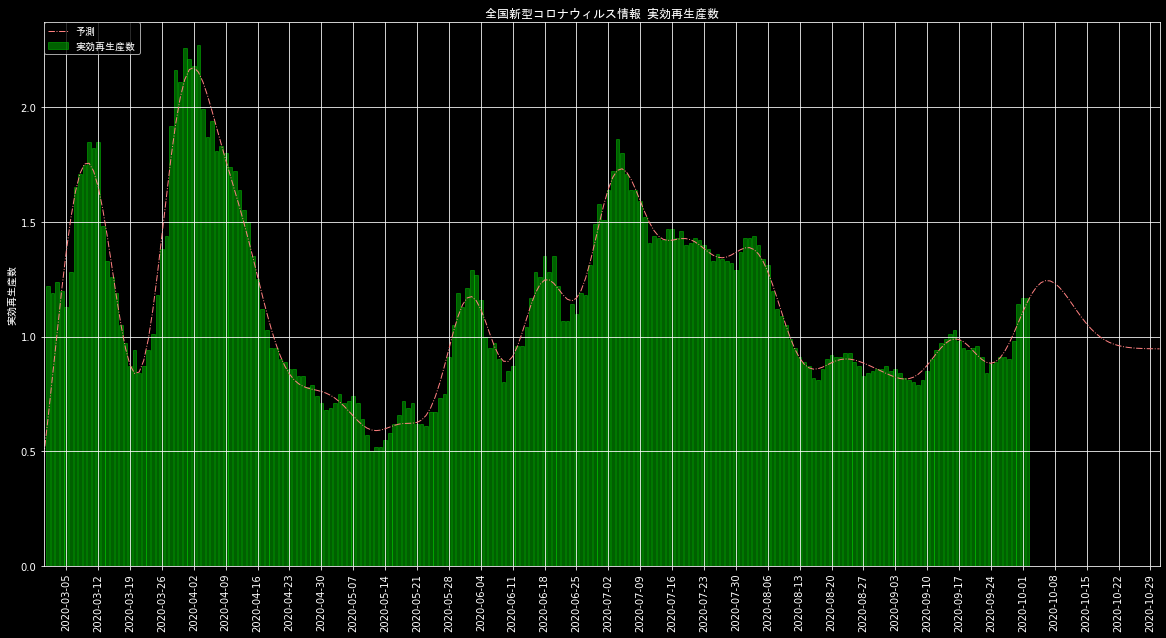

In [19]:
fig, ax = create_basic_plot_figure()
plt.xlim(xbins_pred[44], xbins_pred[-1])
plt.ylim(0, max(ern_data_np[:, 1])+0.1)
plt.ylabel('実効再生産数', fontname=FONT_NAME)
plt.plot(xbins_pred, y_ern, '-.', linewidth=1, color='#ff8080')
plt.bar(xbins, ern_data_np[:, 1], color='#00c000', edgecolor='#00c000', alpha=.5)
plt.legend(labels=["予測値", "実効再生産数"], loc='upper left', borderaxespad=0, fontsize=12, prop={"family":FONT_NAME})
plt.title('全国新型コロナウィルス情報 実効再生産数', fontname=FONT_NAME)
show_and_clear(fig, "ogiwara-ern.jpg")

In [ ]:
tw_body_ern = "全国新型コロナ 実効再生産数＋2週間予測（東洋経済 " + today_str + " 現在）"
tweet_with_image(tw, "ogiwara-ern.jpg", tw_body_ern)